In [2]:
from init import *
import os
import cv2
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from  easydl import clear_output
from torch import nn
import torch
from modules.operates.ops import conv3x3,conv1x1,residualBlock
from modules.blocks.yolo_blocks import C3, Conv

RUNDIR: runs/log/80971
[easydl] tensorflow not available!


In [3]:
class Fusion2Backbone(nn.Module):
    def __init__(self,c1,ns=[],ss=[],c_size=True):
        super(Fusion2Backbone,self).__init__()
        
        self.seq = nn.Sequential()
        self.seq1 = nn.Sequential()
        self.seq2 = nn.Sequential()
        self.cov_act_1 = Cov_Act(3,c1,3,1,1)
        self.cov_act_2 = Cov_Act(3,c1,3,1,1)
        
        c=c1
        for i,(n,s) in enumerate(zip(ns,ss)):
            subseq = nn.Sequential()
            for _ in range(n):
                subseq.add_module('c3_'+str(i)+'_'+str(_),C3(c1,c,1))
            
            
            if not c_size: c*=s
            self.seq.add_module('subseq_'+str(i),subseq)
            self.seq1.add_module('c1_'+str(i),Conv(c1,c,k=3,s=s,p=1))
            c1=c
            
            self.seq2.add_module('c1_'+str(i),Conv(c1*2,c1,k=3,s=1,p=1))
        self.cov_act1 = Cov_Act(c1,3,3,1,1)
        self.cov_act2 = Cov_Act(c1,3,3,1,1)
        
    def forward(self,x1,x2):
        if x2  is  None:
            x2 = x1
        x1 = self.cov_act_1(x1)
        x2 = self.cov_act_2(x2)
        for m,m1,m2 in zip(self.seq,self.seq1,self.seq2):
            x1 = m(x1)
            y1 = m1(x1)
            
            x2 = m(x2)
            y2 = m1(x2)
            x1 = torch.cat([y1*0.8,y2*0.2],1)
            x2 = torch.cat([y2*0.8,y1*0.2],1)
            
            x1 = m2(x1)
            x2 = m2(x2)
        x1 = self.cov_act1(x1)
        x2 = self.cov_act2(x2)
        return x1,x2
    
class Cov_Act(nn.Module):
    def __init__(self,c1,c2,k,s,p):
        super(Cov_Act,self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, p, groups=1, bias=False)
        # self.bn = nn.BatchNorm2d(c2,eps=0.001,momentum=0.03)
        self.act = nn.SiLU()
    def forward(self,x):
        x = self.conv(x)
        x = self.act(x)
        return x

In [ ]:
device = 'cuda:5'
epochs=500

cfg['training']['batch_size']=1
cfg0['training']['optimizer']['lr']=0.001
fb = Fusion2Backbone(64,ns=[6,1,1,6,1,1],ss=[1,1,1,1,1,1])
n_claess,train_loader, val_loder = get_dataloader(cfg)
optimizer, scheduler = get_optimizer_scheduler(fb)

fb = fb.train()
fb=fb.to(device).half()


for epoch  in range(epochs): 
    losses =[]
    for images in train_loader:
        optimizer.zero_grad()
        t1 = images['image_mask'].to(device).half()
        t2 = images['image_mask'].to(device).half()
        t1_b = images['image'].to(device).half()
        t2_b = images['image'].to(device).half()
        
        r1,r2 = fb(t1,t2)
        loss = (torch.abs(r1-t1_b).double().sum()/r1.shape.numel() + torch.abs(r2-t2_b).double().sum()/r2.shape.numel())/1.0
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.detach().cpu().numpy())
    print('epoch'+str(epoch)+' :', np.sum(losses)/len(losses))


In [5]:
def show(t1_b):
    img = t1_b[0]
    img = img.detach().cpu().numpy()
    img = img.transpose(1,2,0)
    img = (img-img.min())/img.max()
    img*=255
    img = img.astype(np.uint8)
    return img

In [30]:
img = show(t1_b)
# img = img[:,:,0]
# img[img>1]=[255]

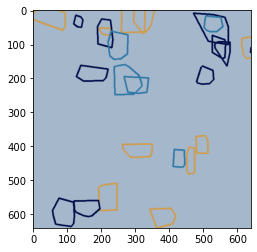

In [31]:
plt.imshow(img,'gray')

In [17]:
# img[img[:,:,0]>10] = [255,255,255]
img = img.astype(np.uint8)
cv2.imwrite('test.png',img)

True